<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

###Load Libraries

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler

###Define Functions to Facilitate Metrics Evaluation

In [327]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [328]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [329]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [330]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

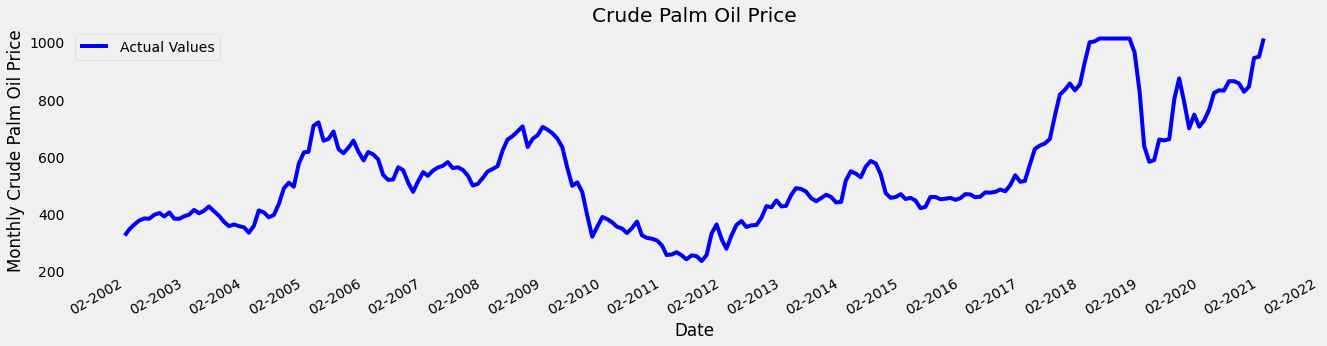

In [331]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [332]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

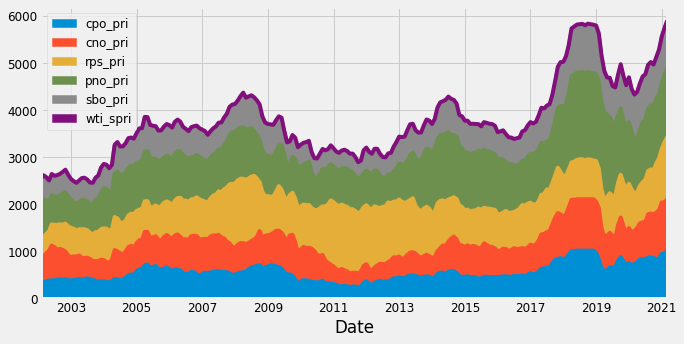

In [333]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [334]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


###Plot Train Test Data

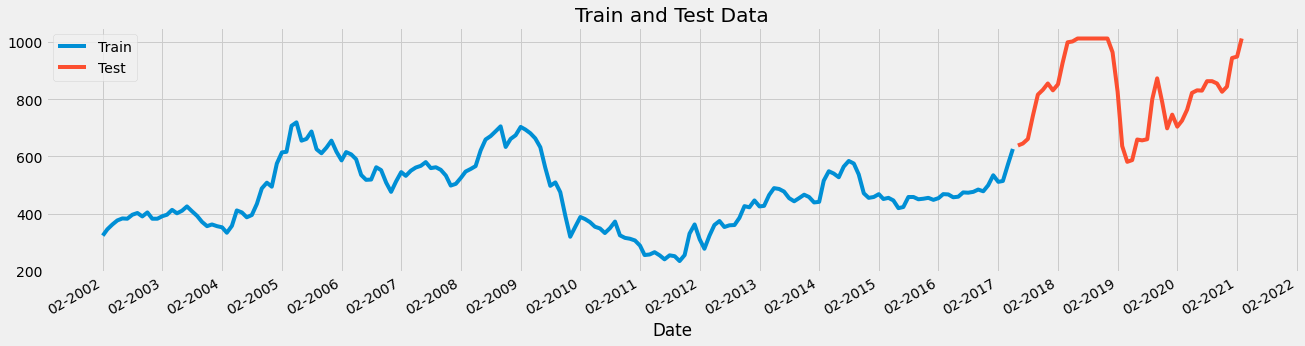

In [335]:
#Plotting data
plt.figure(figsize=(20,5))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [336]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [337]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [338]:
f_transformer = RobustScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,-0.646119,-1.324544,-0.231262,-0.442244,-0.717978
2002-03-01,345.0,-0.230594,-1.348516,-0.395149,-0.338987,-0.856057
2002-04-01,362.0,-0.006849,-1.364539,-0.690145,-0.454392,-0.936328
2002-05-01,376.0,0.180365,-1.351764,-1.068905,-0.600167,-0.950202
2002-06-01,383.0,0.646119,-1.237519,-1.050696,-0.679128,-0.928400


In [339]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.801187
2002-03-01   -0.670623
2002-04-01   -0.569733
2002-05-01   -0.486647
2002-06-01   -0.445104
Name: cpo_pri, dtype: float64

In [340]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.614155,0.012901,0.597786,0.950695,-0.031877
2017-07-01,645.0,0.760274,0.197485,0.396351,1.058264,-0.007763
2017-08-01,661.0,0.787671,0.100871,0.537949,1.082499,-0.131968
2017-09-01,743.0,1.057078,0.093017,0.621567,1.293083,-0.091007
2017-10-01,816.0,1.358447,0.169917,0.953857,1.505672,-0.215212


In [341]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    1.068249
2017-07-01    1.109792
2017-08-01    1.204748
2017-09-01    1.691395
2017-10-01    2.124629
Name: cpo_pri, dtype: float64

In [280]:
len(test)

46

In [281]:
test.index

DatetimeIndex(['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

###Create X_train, y_train, X_test and y_test

In [342]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(183, 1, 6) (183,)


In [343]:
test_lag = test[1:46]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["Date"]).unstack().shift(3).stack()

###Create Model

In [344]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1))
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 1, 128)            896       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 50)                6450      
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7,397
Trainable params: 7,397
Non-trainable params: 0
___________________________________________________

###Train the model

In [345]:
history = cnn_model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
6/6 [==============================] - 1s 39ms/step - loss: 0.4818 - val_loss: 0.0773
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.3328 - val_loss: 0.0629
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.2392 - val_loss: 0.0516
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1699 - val_loss: 0.0426
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1203 - val_loss: 0.0356
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0868 - val_loss: 0.0303
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0656 - val_loss: 0.0267
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0530 - val_loss: 0.0245
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.0230
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0378 - val_loss: 0.0215
Epoch 11/100
6/6 [==========

###Model Summary

In [346]:
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 1, 128)            896       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 50)                6450      
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7,397
Trainable params: 7,397
Non-trainable params: 0
___________________________________________________

###Predict the test data

In [347]:
y_pred = cnn_model.predict(X_test)
y_pred

array([[0.8522637 ],
       [0.8387246 ],
       [0.8977718 ],
       [1.1732948 ],
       [1.3589493 ],
       [1.2881306 ],
       [1.4542533 ],
       [1.3880148 ],
       [1.4959842 ],
       [1.637752  ],
       [1.6878921 ],
       [1.6805195 ],
       [1.7152991 ],
       [1.7149246 ],
       [1.7126238 ],
       [1.7175373 ],
       [1.7010128 ],
       [1.7061538 ],
       [1.7059617 ],
       [1.477876  ],
       [0.94530827],
       [0.6773371 ],
       [0.5744793 ],
       [0.46489817],
       [0.8059367 ],
       [0.85838884],
       [0.9401994 ],
       [1.4172226 ],
       [1.6821926 ],
       [1.502321  ],
       [1.1806629 ],
       [1.3299936 ],
       [1.2626835 ],
       [1.4779884 ],
       [1.6675876 ],
       [1.8481257 ],
       [1.7436458 ],
       [1.6481305 ],
       [1.5412233 ],
       [1.4760442 ],
       [1.4333767 ],
       [1.1778023 ],
       [1.2349907 ],
       [1.609518  ],
       [1.5890183 ]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [348]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[345. 362. 376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413.
  401. 410. 425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404.
  387. 395. 434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687.
  625. 611. 631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552.
  508. 476. 513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498.
  504. 525. 547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703.
  694. 681. 663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.
  354. 348. 332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254.
  240. 254. 251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359.
  360. 385. 426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454.
  466. 458. 439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455.
  458. 468. 451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454.
  468. 467. 457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572.
  626.]]
[[ 645.    661.    743.    816.    833.    855.    831.

###Plot history, actual and predicted value

In [349]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 645.  ,  661.  ,  743.  ,  816.  ,  833.  ,  855.  ,  831.  ,
        852.  ,  926.  ,  999.  , 1002.  , 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25, 1012.25, 1012.25,  964.  ,  826.  ,  636.  ,
        581.  ,  587.  ,  659.  ,  656.  ,  660.  ,  800.  ,  873.  ,
        789.  ,  698.  ,  746.  ,  704.  ,  725.  ,  763.  ,  822.  ,
        831.  ,  830.  ,  863.  ,  863.  ,  855.  ,  826.  ,  844.  ,
        944.  ,  949.  , 1012.25])

In [350]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([601.60645, 599.3251 , 609.27454, 655.7002 , 686.983  , 675.05005,
       703.0417 , 691.8805 , 710.07336, 733.9612 , 742.4098 , 741.16754,
       747.0279 , 746.9648 , 746.57715, 747.405  , 744.62067, 745.48694,
       745.4546 , 707.0221 , 617.2844 , 572.1313 , 554.79974, 536.3353 ,
       593.80035, 602.63855, 616.4236 , 696.802  , 741.44946, 711.1411 ,
       656.9417 , 682.10394, 670.7622 , 707.041  , 738.9885 , 769.4092 ,
       751.8043 , 735.70996, 717.69617, 706.71344, 699.524  , 656.4597 ,
       666.09595, 729.2038 , 725.74963], dtype=float32)

###Plot Actual and Predicted Value 

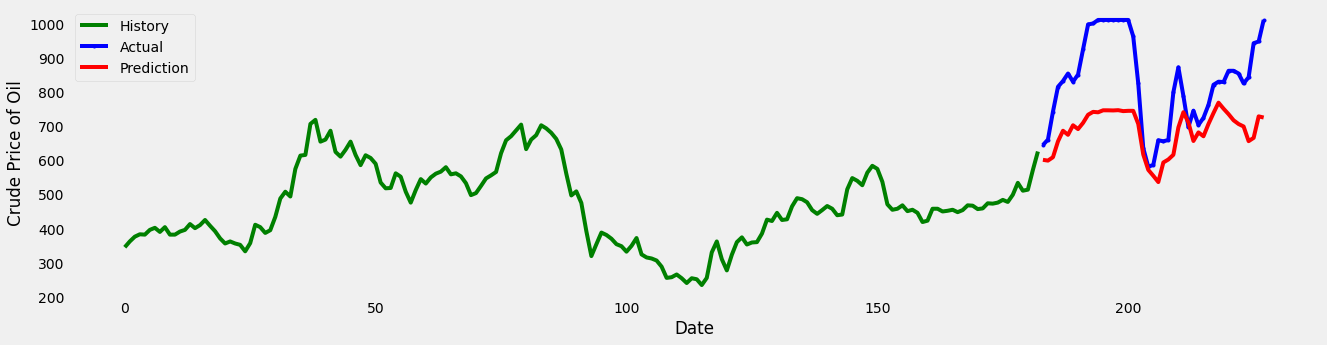

In [367]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Date')
plt.legend()
plt.show();

###Plot Actual and Predicted Value Zoomed-In

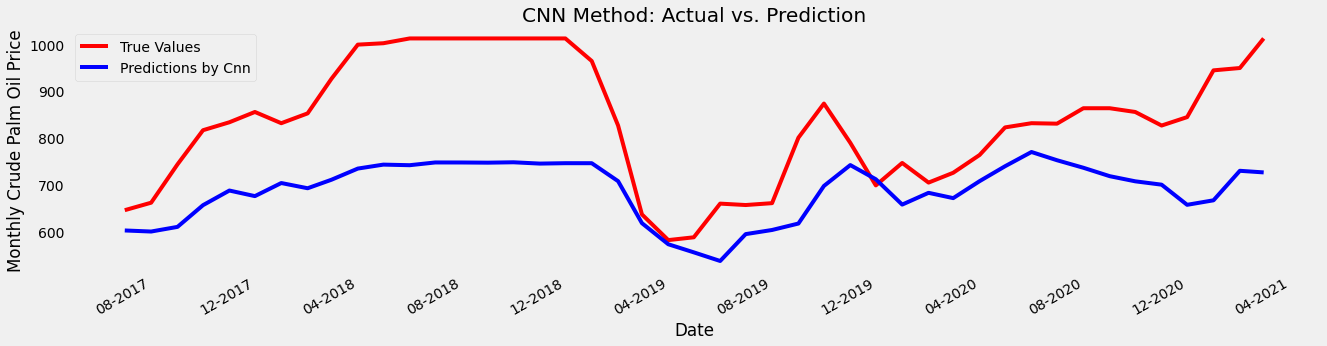

In [364]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(test_lag.index, y_test_inv, color = 'red',  label = 'Test')
plt.plot(test_lag.index,  y_pred_inv, color = 'blue',label = 'CNN Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by Cnn', 'CNN Prediction'],loc='best')
plt.title('CNN Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Evaluate MLP Model Accuracy

In [368]:
MAEcnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAEcnn)

MDAcnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDAcnn)

MAPEcnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPEcnn)

RMSEcnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSEcnn)

MSEcnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSEcnn)

EVScnn = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVScnn)

MAE value of the SVR Model is: 147.6275634765625
MDA value of the SVR Model is: 0.5
MAPE value of the SVR Model is: 16.569586672803418
RMSE value of the SVR Model is: 171.8592684321338
MSE value of the SVR Model is: 29535.608146028222
EVS score of the MLP Model is: 0.5310670192875048


In [ ]:
...updating